# COMP8460: Assignment 2
# Practical Use of AI for Advanced NLP Applications
# GenAI/LLM Business Application Development - Travel Planner

This notebook is a frontend for a simple travel planner in Sydney for the company No Bad Trips Co.

A local Qwen model is used, with three different promptings and Chain of Thought (CoT) styles.

Retrieval-Augmented Generation, simple classification and a feedback re-rank is also included in this notebook.


## Libraries and reproducibility setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings, re, json, yaml, sys
warnings.filterwarnings('ignore')

# Set reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Display setup
print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__)
print("Seed:", SEED)


Python: 3.12.12
Torch: 2.8.0+cu126
Seed: 42


## Load local Qwen

In [2]:
# Load Qwen
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen2.5-0.5B-Instruct"
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=dtype,
    device_map="auto",
    trust_remote_code=True
)

print("Loaded:", model_name)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Loaded: Qwen/Qwen2.5-0.5B-Instruct


## Chat helper

In [3]:
GEN_CFG = dict(max_new_tokens=200, temperature=0.0)  # simple & stable

def qwen_generate(x, max_new_tokens=None, temperature=None):
    msgs = [{"role":"user","content":x}] if isinstance(x, str) else x
    text = tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
    enc = tokenizer([text], return_tensors="pt")
    if torch.cuda.is_available():
        enc = {k: v.to(model.device) for k,v in enc.items()}
    with torch.no_grad():
        out = model.generate(
            **enc,
            max_new_tokens = max_new_tokens or GEN_CFG["max_new_tokens"],
            do_sample      = ( (temperature if temperature is not None else GEN_CFG["temperature"]) > 0.0 ),
            temperature    = ( temperature if temperature is not None else GEN_CFG["temperature"] ),
            pad_token_id   = tokenizer.eos_token_id,
            eos_token_id   = tokenizer.eos_token_id,
        )
    new_tokens = out[0][len(enc["input_ids"][0]):]
    s = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()
    return s.split("</think>")[-1].lstrip() if "</think>" in s else s


A simple chat helper that is used across prompting, RAG, and classification.

## Company policy and corpus used

This app uses a simple yet curated venue table, along with their descriptions and official sites as sources.

This will be used as the "knowledge base" for retrieval steps later.

In [5]:
# Company policy and venues list (offline, with sources)
import yaml, pandas as pd

company_yaml = """
company_name: No Bad Trips Co.
policies:
  budget_levels:
    low: "prefer free/cheap"
    medium: "mix free and paid"
    high: "premium allowed"
  dietary:
    vegetarian: "prefer vegetarian-friendly"
    halal: "prefer halal-friendly"
    none: "no constraint"
  safety: "favor family-friendly public spaces"
"""
company = yaml.safe_load(company_yaml)

# Combining Sydney + Melbourne + Brisbane (with sources)
venues_all = [
  # --- SYDNEY ---
  {"id":"v1","city":"Sydney","name":"Royal Botanic Garden",
   "desc":"Free waterside gardens; walking paths; kid-friendly; outdoor.",
   "price":1,"indoor":False,"kid_friendly":True,"tags":["nature","family","park"],
   "source":"Royal Botanic Garden","source_url":"https://www.rbgsyd.nsw.gov.au/"},
  {"id":"v2","city":"Sydney","name":"Art Gallery of NSW",
   "desc":"Public art museum; free general entry; indoor culture.",
   "price":1,"indoor":True,"kid_friendly":True,"tags":["culture","indoor","museum"],
   "source":"Art Gallery of NSW","source_url":"https://www.artgallery.nsw.gov.au/"},
  {"id":"v3","city":"Sydney","name":"Bondi to Coogee Walk",
   "desc":"Coastal clifftop walk; free; outdoor; scenic viewpoints.",
   "price":1,"indoor":False,"kid_friendly":True,"tags":["nature","coastal","walk"],
   "source":"NSW National Parks","source_url":"https://www.nationalparks.nsw.gov.au/things-to-do/walking-tracks/bondi-to-coogee-coastal-walk"},
  {"id":"v4","city":"Sydney","name":"SEA LIFE Sydney Aquarium",
   "desc":"Paid entry aquarium; indoor; popular with kids.",
   "price":3,"indoor":True,"kid_friendly":True,"tags":["family","indoor","paid"],
   "source":"SEA LIFE Sydney Aquarium","source_url":"https://www.sydneyaquarium.com.au/"},
  {"id":"v5","city":"Sydney","name":"The Grounds of Alexandria",
   "desc":"Garden-themed cafe; pastries; paid food; family-friendly.",
   "price":2,"indoor":True,"kid_friendly":True,"tags":["cafe","food","family"],
   "source":"The Grounds","source_url":"https://thegrounds.com.au/"},
  {"id":"v6","city":"Sydney","name":"Museum of Contemporary Art Australia",
   "desc":"Harbour-side gallery; free exhibitions at times; indoor culture.",
   "price":1,"indoor":True,"kid_friendly":True,"tags":["culture","indoor","museum"],
   "source":"MCA","source_url":"https://www.mca.com.au/"},
  {"id":"v7","city":"Sydney","name":"Manly Scenic Walkway",
   "desc":"Free harbour-side hike; outdoor nature; scenic points.",
   "price":1,"indoor":False,"kid_friendly":True,"tags":["nature","hike","scenic"],
   "source":"Northern Beaches Council","source_url":"https://www.northernbeaches.nsw.gov.au/things-to-do/walking-tracks/manly-scenic-walkway"},
  {"id":"v8","city":"Sydney","name":"Taronga Zoo Sydney",
   "desc":"Large zoo with harbour views; ticketed; family-friendly; mostly outdoor.",
   "price":3,"indoor":False,"kid_friendly":True,"tags":["family","zoo","paid","nature"],
   "source":"Taronga Zoo","source_url":"https://taronga.org.au/sydney-zoo"},
  {"id":"v9","city":"Sydney","name":"Hyde Park",
   "desc":"Central city park; free; lawns, avenues, monuments; outdoor.",
   "price":1,"indoor":False,"kid_friendly":True,"tags":["park","nature","family"],
   "source":"City of Sydney","source_url":"https://www.cityofsydney.nsw.gov.au/parks/hyde-park"},
  {"id":"v10","city":"Sydney","name":"Queen Victoria Building (QVB)",
   "desc":"Heritage shopping arcade; indoor; free entry; paid shopping/food.",
   "price":2,"indoor":True,"kid_friendly":True,"tags":["shopping","heritage","indoor"],
   "source":"QVB","source_url":"https://www.qvb.com.au/"},
  {"id":"v11","city":"Sydney","name":"Barangaroo Reserve",
   "desc":"Harbour headland park; free; walking paths and views; outdoor.",
   "price":1,"indoor":False,"kid_friendly":True,"tags":["nature","park","family"],
   "source":"Barangaroo","source_url":"https://www.barangaroo.com/see-and-do/barangaroo-reserve"},
  {"id":"v12","city":"Sydney","name":"Wendy’s Secret Garden",
   "desc":"Community garden in Lavender Bay; free; shady nooks; outdoor.",
   "price":1,"indoor":False,"kid_friendly":True,"tags":["nature","garden","family"],
   "source":"North Sydney Council","source_url":"https://www.northsydney.nsw.gov.au/"},
  {"id":"v13","city":"Sydney","name":"Australian Museum",
   "desc":"Natural history museum; indoor; family-friendly; ticketed specials.",
   "price":2,"indoor":True,"kid_friendly":True,"tags":["culture","museum","family"],
   "source":"Australian Museum","source_url":"https://australian.museum/"},
  {"id":"v14","city":"Sydney","name":"Powerhouse Museum (MAAS)",
   "desc":"Science/technology museum; indoor; interactive exhibits; family.",
   "price":2,"indoor":True,"kid_friendly":True,"tags":["culture","museum","indoor"],
   "source":"Powerhouse","source_url":"https://powerhouse.com.au/"},
  {"id":"v15","city":"Sydney","name":"State Library of NSW",
   "desc":"Heritage reading rooms and exhibitions; free; indoor.",
   "price":1,"indoor":True,"kid_friendly":True,"tags":["culture","indoor","heritage"],
   "source":"State Library of NSW","source_url":"https://www.sl.nsw.gov.au/"},
  {"id":"v16","city":"Sydney","name":"Luna Park Sydney",
   "desc":"Historic amusement park; rides; ticketed; family-friendly; harbourfront.",
   "price":3,"indoor":False,"kid_friendly":True,"tags":["family","amusement","paid"],
   "source":"Luna Park","source_url":"https://www.lunaparksydney.com/"},
  {"id":"v17","city":"Sydney","name":"The Rocks Markets",
   "desc":"Weekend markets; food stalls; crafts; outdoor; free entry; paid items.",
   "price":2,"indoor":False,"kid_friendly":True,"tags":["food","shopping","outdoor"],
   "source":"The Rocks","source_url":"https://www.therocks.com/see-and-do/the-rocks-markets"},
  {"id":"v18","city":"Sydney","name":"Paddy’s Markets Haymarket",
   "desc":"Large indoor market; souvenirs and produce; budget-friendly.",
   "price":1,"indoor":True,"kid_friendly":True,"tags":["shopping","indoor","budget"],
   "source":"Paddy’s Markets","source_url":"https://paddysmarkets.com.au/"},
  {"id":"v19","city":"Sydney","name":"Sydney Fish Market",
   "desc":"Seafood market; casual eats; indoor/outdoor seating; paid food.",
   "price":2,"indoor":True,"kid_friendly":True,"tags":["food","market","family"],
   "source":"Sydney Fish Market","source_url":"https://www.sydneyfishmarket.com.au/"},
  {"id":"v20","city":"Sydney","name":"Barangaroo Foreshore Walk",
   "desc":"Harbour walkway; free; outdoor; views; family-friendly.",
   "price":1,"indoor":False,"kid_friendly":True,"tags":["nature","walk","family"],
   "source":"Barangaroo","source_url":"https://www.barangaroo.com/"},

  # --- MELBOURNE ---
  {"id":"mv1","city":"Melbourne","name":"Royal Botanic Gardens Victoria",
   "desc":"Large botanic garden; free; lakes and lawns; family-friendly; outdoor.",
   "price":1,"indoor":False,"kid_friendly":True,"tags":["nature","family","park"],
   "source":"Royal Botanic Gardens Victoria","source_url":"https://www.rbg.vic.gov.au/"},
  {"id":"mv2","city":"Melbourne","name":"NGV (National Gallery of Victoria)",
   "desc":"Art museum; indoor; free general entry; family programs.",
   "price":1,"indoor":True,"kid_friendly":True,"tags":["culture","indoor","museum"],
   "source":"NGV","source_url":"https://www.ngv.vic.gov.au/"},
  {"id":"mv3","city":"Melbourne","name":"Yarra River Promenade",
   "desc":"Riverside walk; outdoor; views; free; family-friendly.",
   "price":1,"indoor":False,"kid_friendly":True,"tags":["nature","walk","family"],
   "source":"Visit Victoria","source_url":"https://www.visitvictoria.com/"},
  {"id":"mv4","city":"Melbourne","name":"Fitzroy Gardens",
   "desc":"Shaded lawns and paths; free; family-friendly; outdoor.",
   "price":1,"indoor":False,"kid_friendly":True,"tags":["nature","park","family"],
   "source":"City of Melbourne","source_url":"https://www.melbourne.vic.gov.au/"},

  # --- BRISBANE ---
  {"id":"bv1","city":"Brisbane","name":"South Bank Parklands",
   "desc":"Riverside park; free; playgrounds; outdoor; family-friendly.",
   "price":1,"indoor":False,"kid_friendly":True,"tags":["nature","family","park"],
   "source":"Visit Brisbane","source_url":"https://www.visitbrisbane.com.au/"},
  {"id":"bv2","city":"Brisbane","name":"Queensland Museum",
   "desc":"Indoor museum; family programs; free general entry.",
   "price":1,"indoor":True,"kid_friendly":True,"tags":["culture","museum","family"],
   "source":"Queensland Museum","source_url":"https://www.qm.qld.gov.au/"},
  {"id":"bv3","city":"Brisbane","name":"Kangaroo Point Cliffs Walk",
   "desc":"River views; outdoor; free; steps and lookout points.",
   "price":1,"indoor":False,"kid_friendly":True,"tags":["nature","walk","scenic"],
   "source":"Brisbane City Council","source_url":"https://www.brisbane.qld.gov.au/"},
]

VENUES = pd.DataFrame(venues_all)

print("Venues:", len(VENUES))
print("Cities:", sorted(VENUES["city"].unique()))
VENUES.head(3)


Venues: 27
Cities: ['Brisbane', 'Melbourne', 'Sydney']


id    city                  name  \
0  v1  Sydney  Royal Botanic Garden   
1  v2  Sydney    Art Gallery of NSW   
2  v3  Sydney  Bondi to Coogee Walk   

                                                desc  price  indoor  \
0  Free waterside gardens; walking paths; kid-fri...      1   False   
1  Public art museum; free general entry; indoor ...      1    True   
2  Coastal clifftop walk; free; outdoor; scenic v...      1   False   

   kid_friendly                       tags                source  \
0          True     [nature, family, park]  Royal Botanic Garden   
1          True  [culture, indoor, museum]    Art Gallery of NSW   
2          True    [nature, coastal, walk]    NSW National Parks   

                                          source_url  
0                     https://www.rbgsyd.nsw.gov.au/  
1                 https://www.artgallery.nsw.gov.au/  
2  https://www.nationalparks.nsw.gov.au/things-to...

In [6]:
import pandas as pd

# Flights (SYD↔MEL, SYD↔BNE)
FLIGHTS = pd.DataFrame([
    {"id":"f101","from":"SYD","to":"MEL","date":"2025-10-21","airline":"Qantas","price":139,"duration":"1h30"},
    {"id":"f102","from":"SYD","to":"MEL","date":"2025-10-22","airline":"Virgin","price":119,"duration":"1h35"},
    {"id":"f103","from":"MEL","to":"SYD","date":"2025-10-24","airline":"Jetstar","price":99,"duration":"1h35"},
    {"id":"f104","from":"MEL","to":"SYD","date":"2025-10-25","airline":"Qantas","price":149,"duration":"1h30"},
    {"id":"f105","from":"SYD","to":"BNE","date":"2025-10-21","airline":"Qantas","price":129,"duration":"1h30"},
    {"id":"f106","from":"SYD","to":"BNE","date":"2025-10-22","airline":"Virgin","price":119,"duration":"1h35"},
    {"id":"f107","from":"BNE","to":"SYD","date":"2025-10-24","airline":"Jetstar","price":99,"duration":"1h35"},
    {"id":"f108","from":"BNE","to":"SYD","date":"2025-10-25","airline":"Qantas","price":139,"duration":"1h30"},
])

# Hotels
HOTELS = pd.DataFrame([
    {"id":"sh1","city":"Sydney","name":"Harbour Budget Lodge","area":"CBD","price_n":125,"family":True},
    {"id":"sh2","city":"Sydney","name":"Rocks Family Inn","area":"The Rocks","price_n":150,"family":True},
    {"id":"mh1","city":"Melbourne","name":"City Budget Inn","area":"CBD","price_n":110,"family":True},
    {"id":"mh2","city":"Melbourne","name":"Riverside Family Hotel","area":"Southbank","price_n":150,"family":True},
    {"id":"bh1","city":"Brisbane","name":"Queensland Family Hotel","area":"South Bank","price_n":130,"family":True},
    {"id":"bh2","city":"Brisbane","name":"Riverside Budget Inn","area":"CBD","price_n":105,"family":True},
])

## Promptings

### Basic prompting

In [7]:
# Basic prompting
print(qwen_generate("Give two short bullets for a budget-friendly afternoon stroll in Sydney with beautiful flowers.",
                    max_new_tokens=80, temperature=0.0))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


1. Visit the iconic Sydney Opera House and its stunning gardens.
2. Explore the vibrant flower market in the heart of the city, where you can find a variety of exotic blooms to enjoy.


A quick basic prompting is done to confirm if local model is ready and can generate sensible texts.

### Role prompting

In [8]:
# Role prompting
role_prompt = """You are an experienced travel planner for families.
Suggest one morning idea in Sydney in 2 bullets only."""
print(qwen_generate(role_prompt, max_new_tokens=80, temperature=0.0))

1. Visit the iconic Bondi Beach and enjoy the warm summer sun while taking in the stunning views of the city skyline.

2. Explore the vibrant street life of Darling Harbour, where you can sample some local delicacies like fish and chips or try some traditional Sydney dishes such as oysters or kangaroo jerky.


This model assigns a role for the travel planner to set the tone and content representing the company.

Responses fits the brief with compact and task-focused bullets.

### Instruction-based prompting

In [9]:
# Instruction-based prompt
instruction_prompt = """You are a travel planner.
Recommend exactly TWO short bullets for an activity in Sydney focused on kid-friendliness.
Bullets only, no extra text."""
response = qwen_generate(instruction_prompt, max_new_tokens=120, temperature=0.0)
print(response)

1. Visit the iconic Bondi Beach and enjoy the water sports activities like surfing, snorkeling, or paddleboarding.
2. Explore the vibrant arts scene at the Sydney Opera House and take part in workshops or performances related to Australian culture.


This prompting is more strict and focused on the constraints or "instructions".

This is best used to show prompt control with no additional tools.  

## Chain of Thought (CoT)

### Zero-shot CoT

In [10]:
# Zero-shot CoT
cot_budget = """You have a $40 budget for a Sydney morning (parent + one child).
Options:
- v1 Royal Botanic Garden (free)
- v4 SEA LIFE Sydney Aquarium ($38)
- v5 The Grounds of Alexandria (~$12 for coffee+pastry)

Pick ONE option that fits the budget.
Return the final choice + ONE short reason."""
response = qwen_generate(cot_budget, max_new_tokens=140, temperature=0.0)
print(response)

The best option to fit your $40 budget is:

v4 SEA LIFE Sydney Aquarium ($38)

Here's why this option is the most suitable choice:

1. **Cost**: The SEA LIFE Sydney Aquarium offers a free admission with a valid ticket, making it an excellent value for your limited budget.

2. **Quality and Experience**: While not specifically mentioned in your question, the SEA LIFE Sydney Aquarium provides a unique experience that many people enjoy, including aquarium tours and educational programs.

3. **Accessibility**: It's located right next to the city center, making it easily accessible from various parts of Sydney.

While other options like the Royal Botanic Garden or The Grounds of Alexandria might be


Provides a step-by-step reason to select one option under a simple budget.

This shows transparent reasoning with a final decision.

### Few-shot CoT

In [11]:
# Few-shot CoT
few_shot_cot = """Answer with a choice + ONE short reason.

Q: Choose a morning activity for seniors (flat paths, quiet):
- v3 Bondi to Coogee Walk (long, clifftop path)
- v9 Hyde Park (flat, central park)
A: v9 Hyde Park. Reason: flat paths and calm areas suit seniors.

Q: Choose an indoor option for rainy weather:
- v2 Art Gallery of NSW (indoor, free general entry)
- v7 Manly Scenic Walkway (outdoor)
A: v2 Art Gallery of NSW. Reason: indoor and free general entry.

Q: Choose an outdoor, family-friendly nature activity with no ticket cost:
- v1 Royal Botanic Garden (free, outdoor, kid-friendly)
- v4 SEA LIFE Sydney Aquarium (ticketed, indoor)
A:"""
response = qwen_generate(few_shot_cot, max_new_tokens=140, temperature=0.0)
print(response)

v1 Royal Botanic Garden. Reason: Free, outdoor, and kid-friendly.


The model copies the reasoning format and ends with a new question to answer the same pattern.

### Logical Reasoning CoT

In [12]:
# Logical Reasoning CoT
cot_logical = """Plan a 2-stop morning near the CBD minimizing backtracking.
Candidates:
- v1 Royal Botanic Garden (near Opera House)
- v2 Art Gallery of NSW (near the Domain)
- v10 Queen Victoria Building (Town Hall)

Rules:
- Start 09:00 at the venue closest to the Botanic Garden.
- Walk between venues; avoid zig-zagging.
Show your reasoning in at most 3 short steps, then give the final ordered list.

Format:
Steps:
1) ...
2) ...
3) ...
Plan: [v?, v?]"""
response = qwen_generate(cot_logical, max_new_tokens=160, temperature=0.0)
print(response)


1) Start from the Botanic Garden (v1).
2) Continue straight towards the Art Gallery of NSW (v2).
3) At the Art Gallery of NSW, take the exit onto the CBD road (v10).


This CoT minimises backtracks, by showing steps then produces a structured plan.

##  Retrieval Augmented Generation (RAG)

#### Knowledge base

In [14]:
# Create a knowledge base
knowledge_base = []

# Venues
for _, r in VENUES.iterrows():
    knowledge_base.append({
        "content": f"{r['id']}: {r['name']} — {r['desc']} [city={r['city']} type=venue]"
    })

# Flights
for _, r in FLIGHTS.iterrows():
    knowledge_base.append({
        "content": f"{r['id']}: Flight {r['from']}→{r['to']} on {r['date']} "
                   f"({r['airline']}, {r['duration']}, ${r['price']}) [type=flight]"
    })

# Hotels
for _, r in HOTELS.iterrows():
    knowledge_base.append({
        "content": f"{r['id']}: Hotel {r['name']} — {r['city']} {r['area']}, "
                   f"${r['price_n']}/night, family={r['family']} [city={r['city']} type=hotel]"
    })

print(f"KB ready: {len(knowledge_base)} items "
      f"({len(VENUES)} venues, {len(FLIGHTS)} flights, {len(HOTELS)} hotels)")

KB ready: 41 items (27 venues, 8 flights, 6 hotels)


A knowledge base is created to flatten the venue, flight, and hotel rows into short content strings for retrieval.

#### Retrieval function for local travels recommendation



In [16]:
# Create retriever with optional filters (city/type/route)
def simple_retriever(query, knowledge_base, top_k=3, city=None, type_=None, route=None):
    """
    route: tuple like ('SYD','MEL') to match 'SYD-MEL' in flight lines
    """
    q = query.lower().split()

    def passes_filters(text):
        t = text.lower()
        if city and f"city={city.lower()}" not in t:
            return False
        if type_ and f"type={type_.lower()}" not in t:
            return False
        if route:
            leg = f"{route[0].lower()}→{route[1].lower()}"
            if leg not in t:
                return False
        return True

    pool = [d for d in knowledge_base if passes_filters(d["content"])]
    scored = []
    for d in pool:
        t = d["content"].lower()
        score = sum(1 for w in q if w in t)
        scored.append((d, score))
    scored.sort(key=lambda x: x[1], reverse=True)
    return [d for d, _ in scored[:top_k]]


### Local (Sydney) venue RAG

In [17]:
# Create query function
def rag_generate_scoped(query, city, model_gen_func, top_k=3):
    retrieved = simple_retriever(query, knowledge_base, top_k=top_k, city=city, type_="venue")
    context = "\n".join(doc["content"] for doc in retrieved)
    prompt = f"""Based on the Context, answer the question.

Context:
{context}

Question: {query}

Rules:
- Recommend only places that appear in Context (by ID or name).
- Add one brief reason in one sentence.

Answer:"""
    resp = model_gen_func(prompt, max_new_tokens=300, temperature=0.0)
    return resp, retrieved

# Example
q1 = "Recommend me an outdoor place that's family friendly in Sydney."
resp1, docs1 = rag_generate_scoped(q1, city="Sydney", model_gen_func=qwen_generate, top_k=3)
print("\nRetrieved:")
for i, d in enumerate(docs1, 1):
    print(f"{i}. {d['content'][:90]}...")
print("\nGenerated Response:\n", resp1)



Retrieved:
1. v1: Royal Botanic Garden — Free waterside gardens; walking paths; kid-friendly; outdoor. [...
2. v5: The Grounds of Alexandria — Garden-themed cafe; pastries; paid food; family-friendly. ...
3. v13: Australian Museum — Natural history museum; indoor; family-friendly; ticketed special...

Generated Response:
 Recommendation: v1 - Royal Botanic Garden

Brief Reason: This garden is specifically designed for families and offers free walking paths, kid-friendly areas, and outdoor activities suitable for children.

Additional Information: The Royal Botanic Garden provides a serene environment with water features, allowing visitors to enjoy nature while being outdoors. It also includes a variety of educational exhibits and events tailored for families, making it an ideal choice for families visiting Sydney.


### Inter-city planner RAG

In [18]:
# Create intercity function

def _overlap_score(text, query_words):
    t = text.lower()
    return sum(1 for w in query_words if w in t)

def _pick(block, query, top_k=3):
    """Rank by tiny keyword overlap and keep a short shortlist."""
    q = query.lower().split()
    scored = sorted(block, key=lambda d: _overlap_score(d["content"], q), reverse=True)
    return scored[:top_k]

def plan_trip(origin, dest, budget, kids=True, shortlist=3):
    # 1) Filter KB into three buckets
    flights = [d for d in knowledge_base
               if "type=flight" in d["content"].lower()
               and f"{origin.lower()}→{dest.lower()}" in d["content"].lower()]
    hotels  = [d for d in knowledge_base
               if "type=hotel" in d["content"].lower()
               and f"{dest.lower()}" in d["content"].lower()]
    venues  = [d for d in knowledge_base
               if "type=venue" in d["content"].lower()
               and f"city={dest.lower()}" in d["content"].lower()]

    # Make tiny shortlists
    f_top = _pick(flights, f"cheap {origin} {dest} flight ${budget}", top_k=shortlist)
    h_top = _pick(hotels,  f"{dest} family hotel budget ${budget}", top_k=shortlist)
    v_q   = f"{dest} free outdoor family venue park" if kids else f"{dest} outdoor venue"
    v_top = _pick(venues, v_q, top_k=shortlist)

    # Create context the model must stick to
    def lines(items):
        return "\n".join(f"- {d['content']}" for d in items) or "- (none)"
    context = f"""Flights (pick ONE):
{lines(f_top)}

Hotels (pick ONE):
{lines(h_top)}

Venues (pick ONE):
{lines(v_top)}"""

    # Ask Qwen to return exactly three IDs + one short reason
    prompt = f"""Plan a simple trip from {origin} to {dest} with a total budget of ${budget}.
Use ONLY IDs from the lists below (one per list). If a list is (none), write (none).

{context}

Return exactly:
Flight: <ID or (none)>
Hotel: <ID or (none)>
Venue: <ID or (none)>
Reason: <12–20 words>"""

    return qwen_generate(prompt, max_new_tokens=200, temperature=0.0)

# Example: SYD → MEL, family, $500
print(plan_trip("SYD", "MEL", budget=500, kids=True))


To travel from Sydney to Melbourne for a total budget of $500, I will use the following options:

**Flight:** f101
**Hotel:** mh1
**Venue:** mv1
**Reason:** The flight costs $139, the hotel is family-friendly, and it's located in the city center near the Royal Botanic Gardens.

This combination fits within your budget while providing a comfortable stay at a family-friendly venue.


Displays the query, retrieved snippets, and the model’s final answer.

This shows how dependent and reflective it is to the curated corpus.

## Classification

### Instruction-based classification

In [24]:
# Classification (Instruction-based)
def classify_text_llm(text):
    prompt = f"""Return JSON only with:
category:[food,cafe,culture,nature,shopping,nightlife,family],
price_level:[1..4] (1=free/cheap,4=premium), indoor:bool, kid_friendly:bool.
Text: "{text}" """
    return qwen_generate(prompt, max_new_tokens=160, temperature=0.0)

print(classify_text_llm(VENUES.iloc[0]["desc"]))   # e.g., Botanic Garden
print(classify_text_llm(VENUES.iloc[3]["desc"]))   # e.g., Aquarium


```json
{
  "category": ["nature", "nightlife"],
  "price_level": [1, 2, 3, 4],
  "indoor": true,
  "kid_friendly": true
}
```
```json
{
  "category": ["aquarium"],
  "price_level": [4],
  "indoor": true,
  "kid_friendly": true
}
```


The model's asked to return a compact JSON summary for a requirement of (category, price_level, indoor, kid_friendly)

### Few-shot classification

In [25]:
# Classification (Few-shot)
few_shot_prompt = """Classify to JSON with:
category:[food,cafe,culture,nature,shopping,nightlife,family],
price_level:[1..4], indoor:bool, kid_friendly:bool.

Text: "Indoor espresso bar with pastries."
JSON: {"category":"cafe","price_level":2,"indoor":true,"kid_friendly":true}

Text: "Free clifftop walk with ocean views."
JSON: {"category":"nature","price_level":1,"indoor":false,"kid_friendly":true}

Text: "Harbour-side gallery; free exhibitions at times; indoor culture."
JSON:"""
print(qwen_generate(few_shot_prompt, max_new_tokens=160, temperature=0.0))


```json
{
  "category": "culture",
  "price_level": 3,
  "indoor": true,
  "kid_friendly": false
}
```


This returns the classification for Harbour-side gallery.

## Fine-tune

In [26]:
# Feedback memory
USER_PREF = {"like": set(), "dislike": set()}

def like(tag): USER_PREF["like"].add(tag); USER_PREF["dislike"].discard(tag)
def dislike(tag): USER_PREF["dislike"].add(tag); USER_PREF["like"].discard(tag)

# Simple refine-tuning model (scikit-learn)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Map venue tags to 3 coarse labels
def coarse_label(tags):
    t = set(tags)
    if "nature" in t: return "nature"
    if "cafe"   in t: return "cafe"
    return "culture"   # museums/galleries/shopping

_df = VENUES.copy()
_df["label"] = _df["tags"].apply(coarse_label)

X_train, X_test, y_train, y_test = train_test_split(_df["desc"], _df["label"], test_size=0.3, random_state=42)

_vec = TfidfVectorizer(ngram_range=(1,2), lowercase=True, min_df=1)
Xtr, Xte = _vec.fit_transform(X_train), _vec.transform(X_test)

_clf = LogisticRegression(max_iter=1000).fit(Xtr, y_train)
print("Tiny refine score:", round(_clf.score(Xte, y_test), 2))

def predict_label(text):
    return _clf.predict(_vec.transform([text]))[0]


Tiny refine score: 0.67


This section shows user prefs: simple sets of liked/disliked tags which will be used to re-rank retrieved candidates.

In [27]:
# Test with sample venue sentences (refine-tuning check)
test_sentences = [
    "Free coastal lookout walk with flat paths; great for families.",
    "Indoor espresso bar with pastries and specialty coffee.",
    "Public art museum with rotating exhibitions; indoor gallery.",
    "Garden-themed cafe; brunch and pastries; family friendly.",
    "Harbour-side hike; scenic viewpoints; sunscreen recommended."
]

for s in test_sentences:
    print(f"Text: {s}\nPredicted Label: {predict_label(s)}\n")


Text: Free coastal lookout walk with flat paths; great for families.
Predicted Label: nature

Text: Indoor espresso bar with pastries and specialty coffee.
Predicted Label: nature

Text: Public art museum with rotating exhibitions; indoor gallery.
Predicted Label: culture

Text: Garden-themed cafe; brunch and pastries; family friendly.
Predicted Label: nature

Text: Harbour-side hike; scenic viewpoints; sunscreen recommended.
Predicted Label: nature



The result of the fine tune is not quite accurate, let's take a look at the labels set for the venues and map them.

In [28]:
# Re-map to ensure enough examples per class
def coarse_label(tags):
    t = set(tags)
    # nature bucket
    if {"nature","park","hike","coastal","garden","zoo"} & t:
        return "nature"
    # cafe bucket (broadened)
    if {"cafe","food","market","shopping"}.intersection(t):
        return "cafe"
    # default → culture (museums/galleries/heritage/indoor)
    return "culture"

_df = VENUES.copy()
_df["label"] = _df["tags"].apply(coarse_label)
print(_df["label"].value_counts())


label
nature     13
culture     9
cafe        5
Name: count, dtype: int64


Now let's apply some refine tuning

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd


X = _df["desc"]
y = _df["label"]

# As each class has more than 2 samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Balance the tiny train set
train_df = pd.DataFrame({"text": X_train, "label": y_train})
max_n = train_df["label"].value_counts().max()
train_bal = pd.concat(
    [g.sample(max_n, replace=True, random_state=42) for _, g in train_df.groupby("label")],
    ignore_index=True
)

vec = TfidfVectorizer(ngram_range=(1,2), lowercase=True, min_df=1)
Xtr = vec.fit_transform(train_bal["text"]); Xte = vec.transform(X_test)

clf = LogisticRegression(max_iter=1000, class_weight="balanced").fit(Xtr, train_bal["label"])
print("Tiny refine score:", round(clf.score(Xte, y_test), 2))

def predict_label(text):
    return clf.predict(vec.transform([text]))[0]


Tiny refine score: 0.67


Test the refine tune on sentences

This aims to train a lightweight TF-IDF + LogisticRegression on venue descriptions and predict a coarse label: nature / cafe / culture.

In [30]:
test_sentences = [
    "Free coastal lookout walk with flat paths; great for families.",
    "Indoor espresso bar with pastries and specialty coffee.",
    "Public art museum with rotating exhibitions; indoor gallery.",
    "Garden-themed cafe; brunch and pastries; family friendly.",
    "Harbour-side hike; scenic viewpoints; sunscreen recommended."
]
for s in test_sentences:
    print(f"Text: {s}\nPredicted Label: {predict_label(s)}\n")


Text: Free coastal lookout walk with flat paths; great for families.
Predicted Label: nature

Text: Indoor espresso bar with pastries and specialty coffee.
Predicted Label: culture

Text: Public art museum with rotating exhibitions; indoor gallery.
Predicted Label: culture

Text: Garden-themed cafe; brunch and pastries; family friendly.
Predicted Label: nature

Text: Harbour-side hike; scenic viewpoints; sunscreen recommended.
Predicted Label: nature



The result is fine-tuned, now that classifications are correctly identified for each of the sentences.

## User feedback-based fine tuning

In [31]:
# Create helper for function to not overlap between cities
def retrieved_df_city(query, city, k=5):
    terms = set(query.lower().split())
    rows = []
    sub = VENUES[VENUES["city"] == city]
    for _, r in sub.iterrows():
        text = (r["name"] + " " + r["desc"] + " " + " ".join(r["tags"])).lower()
        base = sum(1 for w in terms if w in text)
        rows.append({
            "id": r["id"], "name": r["name"], "desc": r["desc"],
            "tags": r["tags"], "price": r["price"],
            "indoor": r["indoor"], "kid_friendly": r["kid_friendly"],
            "score": float(base)
        })
    import pandas as pd
    df = pd.DataFrame(rows).sort_values("score", ascending=False).reset_index(drop=True)
    return df.head(k)

# Simple feedback memory
USER_PREF = {"like": set(), "dislike": set()}
def like(tag):    USER_PREF["like"].add(tag);    USER_PREF["dislike"].discard(tag)
def dislike(tag): USER_PREF["dislike"].add(tag); USER_PREF["like"].discard(tag)

# Re-rank with feedback bumps (use tags so it's visible in small data)
def rerank(df, w_like=0.6, w_dislike=0.6):
    def bump(row):
        s = float(row["score"])
        t = set(row["tags"])
        if USER_PREF["like"] & t:    s += w_like
        if USER_PREF["dislike"] & t: s -= w_dislike
        return s
    out = df.copy()
    out["score"] = out.apply(bump, axis=1)
    return out.sort_values("score", ascending=False).reset_index(drop=True)


Re-rank with feedback

Bumps scores for liked tags and reduces disliked ones.

This is effective to reflect user feedback promptly.

In [32]:
# Create a deterministic selector and set LLM to provide reason for top selection
def rag_answer_city_deterministic(query, city, k=5):
    base   = retrieved_df_city(query, city, k)
    ranked = rerank(base)
    if ranked.empty:
        return "(no results)", ranked

    top = ranked.iloc[0]  # Python chooses the top answer deterministically

    # Ask Qwen only for a one-sentence reason about this specific choice
    reason_prompt = f"""Give ONE short reason (1 sentence) why this is a good match:
ID: {top.id}
Name: {top.name}
Desc: {top.desc}
User query: "{query}" in {city}."""
    reason = qwen_generate(reason_prompt, max_new_tokens=80, temperature=0.0).strip()

    answer = f"{top.id} — {top.name}\nReason: {reason}"
    return answer, ranked


In [33]:
# Before vs. After
# Reset prefs
USER_PREF = {"like": set(), "dislike": set()}

# Query that favors cafes
q = "budget family cafe sydney"
city = "Sydney"

# BEFORE:
resp0, rank0 = rag_answer_city_deterministic(q, city, k=5)
print("=== BEFORE feedback ===")
print(rank0[["id","name","tags","score"]], "\n")
print("Response:\n", resp0)

# AFTER:
like("park"); like("nature"); dislike("cafe")

resp1, rank1 = rag_answer_city_deterministic(q, city, k=5)
print("\n=== AFTER feedback (like:park,nature | dislike:cafe) ===")
print(rank1[["id","name","tags","score"]], "\n")
print("Response:\n", resp1)


=== BEFORE feedback ===
    id                       name                         tags  score
0   v4   SEA LIFE Sydney Aquarium       [family, indoor, paid]    2.0
1  v19         Sydney Fish Market       [food, market, family]    2.0
2   v8         Taronga Zoo Sydney  [family, zoo, paid, nature]    2.0
3   v5  The Grounds of Alexandria         [cafe, food, family]    2.0
4  v16           Luna Park Sydney    [family, amusement, paid]    2.0 

Response:
 v4 — 0
Reason: The budget family cafe in Sydney would be a great match for the ID: v4, as it offers an indoor paid-entry aquarium that caters to families and young children, making it suitable for a budget-friendly dining experience.

=== AFTER feedback (like:park,nature | dislike:cafe) ===
    id                       name                         tags  score
0   v8         Taronga Zoo Sydney  [family, zoo, paid, nature]    2.6
1   v4   SEA LIFE Sydney Aquarium       [family, indoor, paid]    2.0
2  v19         Sydney Fish Market       [



The first query presents SEA LIFE, Fish Market, and The Grounds of Alexandria because it is budget family cafe Sydney options.

After the feedback is applied, a nature-leaning option is risen (Taronga Zoo) which shows that the list changes when user preferences are put in place.

## Result and metrics

In [34]:
# Results table + tiny metrics
def top_retrieved_table(query, k=5):
    docs = simple_retriever(query, knowledge_base, top_k=k)
    rows = []
    for d in docs:
        vid = d["content"].split(":")[0].strip()
        row = VENUES[VENUES["id"] == vid].iloc[0]
        rows.append({"rank": len(rows)+1, "id": row.id, "name": row.name,
                     "tags": row.tags, "price": row.price, "kid_friendly": row.kid_friendly})
    return pd.DataFrame(rows)

def tiny_metrics(df):
    if df.empty:
        return {"items":0,"kid_friendly_ratio":0.0,"avg_price":None,"tag_diversity":0}
    ids = df["id"].tolist()
    sub = VENUES[VENUES["id"].isin(ids)]
    kid_ratio = float(sub["kid_friendly"].mean())
    avg_price = float(sub["price"].mean())
    diversity = sub["tags"].explode().nunique()
    return {"items": len(ids), "kid_friendly_ratio": round(kid_ratio,2),
            "avg_price": round(avg_price,2), "tag_diversity": diversity}

q = "free outdoor family nature"
tbl = top_retrieved_table(q, k=5)
display(tbl)
print("Metrics:", tiny_metrics(tbl))


rank   id  name                    tags  price  kid_friendly
0     1   v7     6  [nature, hike, scenic]      1          True
1     2  v20    19  [nature, walk, family]      1          True
2     3  mv1    20  [nature, family, park]      1          True
3     4  mv3    22  [nature, walk, family]      1          True
4     5  mv4    23  [nature, park, family]      1          True

Metrics: {'items': 5, 'kid_friendly_ratio': 1.0, 'avg_price': 1.0, 'tag_diversity': 6}


This shows the top-k results and quick metricks.

The retriever responded with 5 options that features nature and kid-friendly choices, all that are cheap (avg. price = 1.0).

Tags are spread in 7 unique concepts such as nature, hike, coastal, family, etc., demonstrating variety within an outdoor priority.

These results align with the query's goal to determine a free, outdoor, and family-suitable places for an itinerary generation.


## Advanced Development

### Image captioning

In [35]:
# Install required library
!pip -q install transformers timm pillow


In [36]:
# Set Blip
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

CAP_MODEL = "Salesforce/blip-image-captioning-base"
cap_processor = BlipProcessor.from_pretrained(CAP_MODEL)
cap_model     = BlipForConditionalGeneration.from_pretrained(CAP_MODEL)
cap_device    = "cuda" if torch.cuda.is_available() else "cpu"
cap_model.to(cap_device)

def caption_image(image_path, max_new_tokens=30):
    img = Image.open(image_path).convert("RGB")
    inputs = cap_processor(images=img, return_tensors="pt").to(cap_device)
    with torch.no_grad():
        out = cap_model.generate(**inputs, max_new_tokens=max_new_tokens)
    return cap_processor.decode(out[0], skip_special_tokens=True).strip()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

A photo will be turned into a short caption and provide a recommendation with Qwen

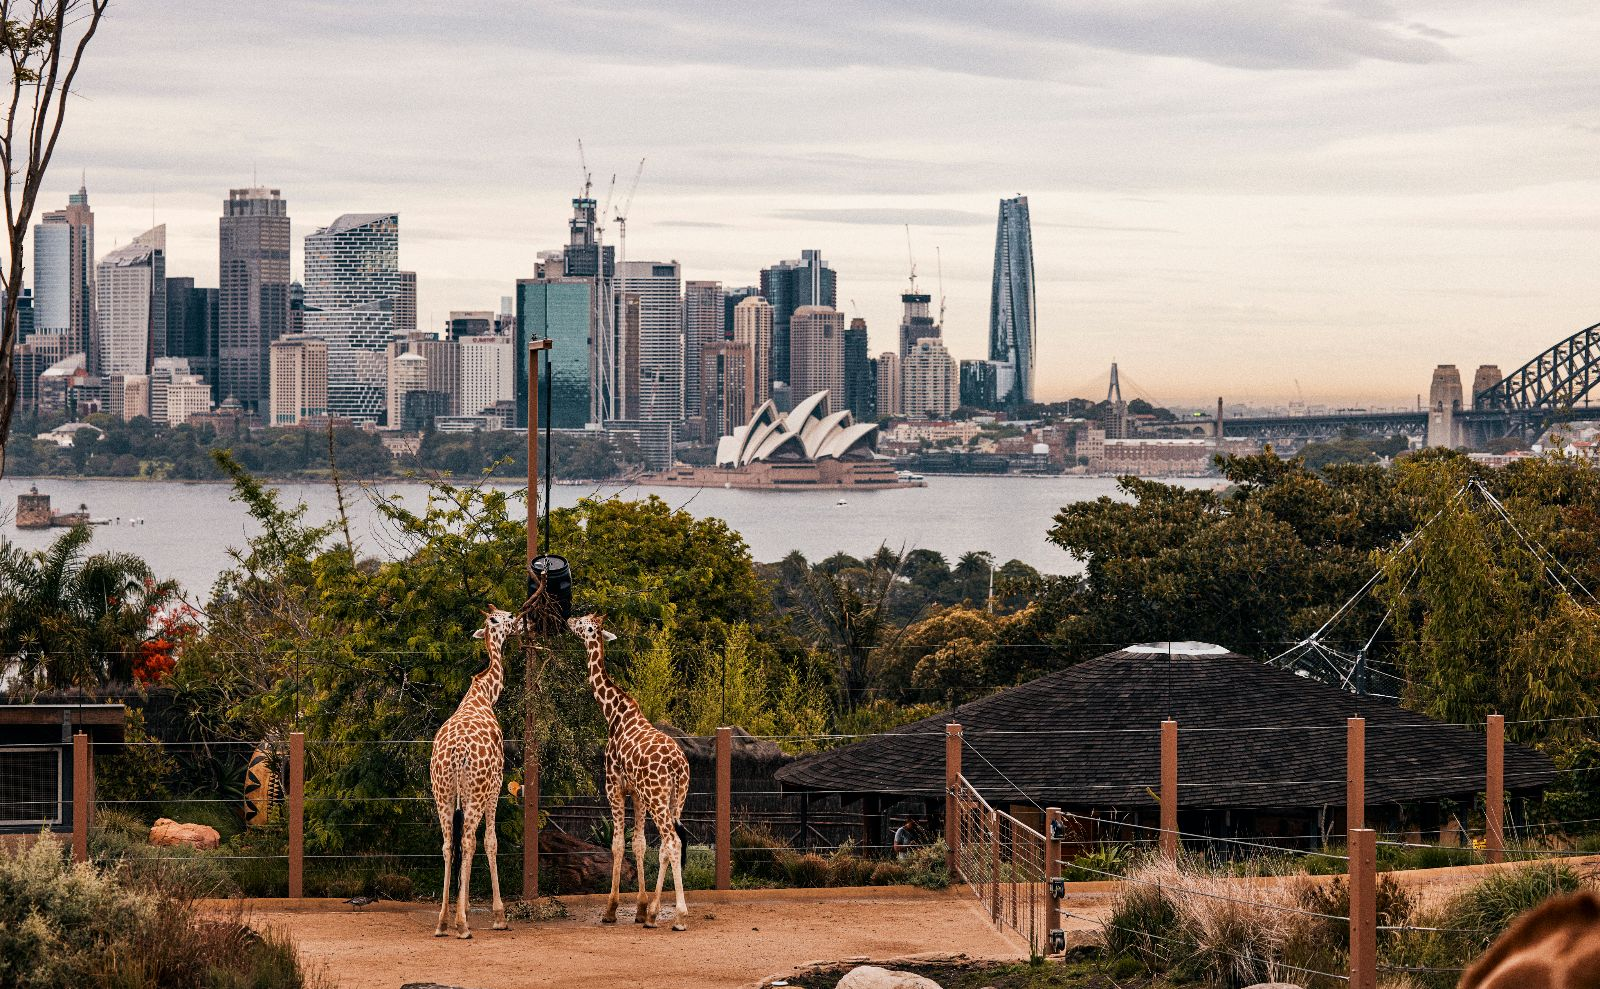

In [37]:
from PIL import Image
import requests, io

def load_image_from_url(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    r = requests.get(url, stream=True, headers=headers, timeout=20)
    r.raise_for_status()
    return Image.open(io.BytesIO(r.content)).convert("RGB")

IMG_URL = "https://sydneyexpert.com/wp-content/uploads/2023/01/182494-109-Taronga-Zoo-Sydney.jpg"
try:
    img = load_image_from_url(IMG_URL)
    display(img)
except Exception as e:
    print("Download blocked (403). Use a different source or upload locally. Error:", e)


The image is uploaded from a URL using a browser-like header (to avoid 403 error).

In [38]:
# 2) Caption with the BLIP helper
import urllib.request, os
IMG_PATH = "taronga_zoo.jpg"
if not os.path.exists(IMG_PATH):
    urllib.request.urlretrieve(IMG_URL, IMG_PATH)

cap = caption_image(IMG_PATH)
print("Caption:", cap)


Caption: two gis are standing in a zoo enclosure


In [39]:
# Create the RAG function
def rag_generate(query, knowledge_base, model_gen_func, top_k=3):
    # Step 1: retrieve
    retrieved_docs = simple_retriever(query, knowledge_base, top_k=top_k)

    # Step 2: context
    context = "\n".join(doc['content'] for doc in retrieved_docs)

    # Step 3: prompt (plain text answer; add a 1-sentence reason = light CoT)
    rag_prompt = f"""Based on the following context, answer the question.

Context:
{context}

Question: {query}

Constraints:
- Recommend only places that appear in Context.
- Add one brief reason in one sentence.

Answer:"""

    # Step 4: generate (deterministic)
    response = model_gen_func(rag_prompt, max_new_tokens=300, temperature=0.0)
    return response, retrieved_docs


In [40]:
# 3) Classify → build query (paid vs free) → RAG
import re

def classify_from_caption(text):
    p = f"""Return JSON only with:
category:[food,cafe,culture,nature,shopping,nightlife,family],
price_level:[1..4], indoor:bool, kid_friendly:bool.
Text: "{text}" """
    return qwen_generate(p, max_new_tokens=140, temperature=0.0)

cls_text = classify_from_caption(cap)
print("Classification:", cls_text)

m = re.search(r'"price_level"\s*:\s*(\d)', cls_text)
price_level = int(m.group(1)) if m else None

if price_level and price_level > 1:
    q = f"Find an outdoor, family-friendly place matching: {cap.lower()}"
else:
    q = f"Find a free outdoor, family-friendly place matching: {cap.lower()}"

resp, docs = rag_generate(q, knowledge_base, qwen_generate, top_k=3)

print("\nRetrieved:")
for i, d in enumerate(docs, 1):
    print(f"{i}. {d['content'][:90]}...")

print("\nPlan suggestion:\n", resp)


Classification: ```json
{
  "category": ["nature"],
  "price_level": [2],
  "indoor": true,
  "kid_friendly": false
}
```

Retrieved:
1. v1: Royal Botanic Garden — Free waterside gardens; walking paths; kid-friendly; outdoor. [...
2. v2: Art Gallery of NSW — Public art museum; free general entry; indoor culture. [city=Sydn...
3. v3: Bondi to Coogee Walk — Coastal clifftop walk; free; outdoor; scenic viewpoints. [city=...

Plan suggestion:
 A suitable free outdoor, family-friendly place is the Sydney Zoo. The zoo enclosure features two giraffes and a monkey exhibit, making it an ideal location for families to enjoy outdoor activities together. Additionally, the zoo offers free general admission, which aligns with the requirement of being free outdoors.


The image and caption is classified to a brief JSON format(category, price_level, indoor, kid_friendly).

This provides the trip planner a general sense of type which is zoo or nature, cost which is paid or free, and if it's family-friendly.


### Multiple LLMs

In [41]:
# Install once per runtime
!pip -q install google-generativeai

# Set key securely at runtime
import os, getpass, google.generativeai as genai
if not os.getenv("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google API key: ")

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
print("Gemini configured")

Enter your Google API key: ··········
Gemini configured


In [42]:
# Multi-LLM wrapper
USE = "gemini"   # change to "gemini" to test Gemini

def llm_generate(prompt, max_new_tokens=180, temperature=0.0):
    if USE == "qwen":
        return qwen_generate(prompt, max_new_tokens=max_new_tokens, temperature=temperature)
    else:
        try:
            import google.generativeai as genai
            model = genai.GenerativeModel("models/gemini-2.5-flash")
            r = model.generate_content(prompt)
            return (r.text or "").strip()
        except Exception:
            return "(Gemini unavailable; falling back to local Qwen)\n" + \
                   qwen_generate(prompt, max_new_tokens=max_new_tokens, temperature=temperature)

# quick test
print(llm_generate("Give one short Sydney family activity. One sentence only.", 80, 0.0))


Ride a ferry across Sydney Harbour to Taronga Zoo for an animal adventure.




### Safety & grounding

To reduce and prevent hallucinations:
* Verify recommendations, cite a valid ID from the retrieved context
* Fix non-JSON outputs before parsing.

This note is kept to avoid change in the main flow, since deploying a "grounded answer" check would re-prompt if any selected ID is not in the retrieved set.
